# Multi-Armed Bandit

A multi-armed bandit is a way of performing an A/B test which in part solves the [stopping problem](http://varianceexplained.org/r/bayesian-ab-testing/). This approach simultaneously allays fears from your boss that your company may be losing money while you run your experiment to completion since you can allocate resources in proportion to your belief that each variant is best.

### Fooling Yourself

Classically, the outcome of an A/B experiment has been determined by performing a hypothesis test with the null hypothesis being that the outcomes for variant A and variant B are the same. A p-value threshold (usually $p=.05$) is typically used to infer whether there is a significant difference between the outcomes or not. 

If you have many variants, which is usually the case in factorial experiment, this means that you will likely be performing many hypothesis tests which means that you will have an increased false positive rate for a fixed $p$ value. If you adjust your $p$ value to maintain a fixed false positive rate, you lose sensitivity as the number of tests you perform scales up.

If you fix the number of samples that you would like to obtain ahead of time for each variant, and only look at the results after having completed the experiment, you may find that there was a significant difference and it was large! If you had run the experiment for a shorter period of time, then you might have gotten the results you wanted faster! This may then lead you to "peak" during the running of the experiment, looking at the p-value as if the experiment had already stopped. If you allow for the option to conditionally stop the experiment based on this "peaking", then you allow for many more possible tests and hence a higher false positive rate than that for a single test.

### Make Use of Your Cumulative Knowledge

A Multi-Armed bandit is an A/B test without hypothesis testing that automatically implements the best variant once it is clear that this is the best one. It does so by allocating resources to the variants in each step of the experiment in proportion to the belief that that variant is the best amongst the variants.

Of course there are trade-offs to this approach. If you do not model your likelihood function accurately, then you could inadvertently dismiss the best variant early on. Additionally, since we are only allocating resources to the best variant, we end up learning much less about the performance of all of the other variants.

### `random_algebra.ab_testing`

I included some objects which can implement a mock Multi-Armed Bandit using the methods to manipulate random variables which are central to this package. The structure of this code is as follows:

- there are `Generator` objects which acquire the data on demand for each variant and provide the likelihood of that data given a single model parameter.
- there are `Variant` objects which contain the cumulative posterior distribution for model parameter and contains a `Generator` object from which to acquire data
- There is a `MultiArmedBandit` object which houses a list of `Variant` object whose model parameters we would like to compare, and which implements the multi-armed bandit approach to allocate measurement resources to those `Variants` we believe are best.

Here is are some examples of the implementation of this infrastructure:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white", font_scale=1.3)

import sys
sys.path.append('..')

from random_algebra import ab_testing as ab
from random_algebra import display_animation

from scipy.stats import beta

### All Variants Are Equal

Here, we are using test variants, `BinomBetaTestVariant` which inherits from `Variant` and has a `Generator` object that simulates a binomial variable with positive outcome probability $p$. Here we construct an experiment, and then run the experiment with 150 steps, and taking 20 samples (distributed amongst the variants) on each step. The `MultiArmedBandit` has a `step` method which allows us to advance the experiment 1 step, `run` which allows us to run a series of steps, and `run_with_animation` which runs a series of steps and creates and animation of the evolution of the probability distributions for the model parameters for the variants. Here is the result:

In [2]:
arms = [ab.BinomBetaTestVariant(.45, 
                                prior=beta(1, 1),
                                name="arm:{i}".format(i=i)) 
        for i in range(4)]

ex = ab.MultiArmedBandit(arms=arms)

steps, samples_per_step = 150, 20

animation = ex.run_with_animation(steps, samples_per_step,
                                  ylim=[0, 25])

display_animation(animation)

Here we see that the experiment does not converge within the allowed time frame on a specific favorite variant that it believes has the best model parameter - this is good since we know that all of the variants have the same model parameter.

We can look more closely at both the belief distribution regarding which variant is best and the allocation of measurement resources as a function of each experiment step.

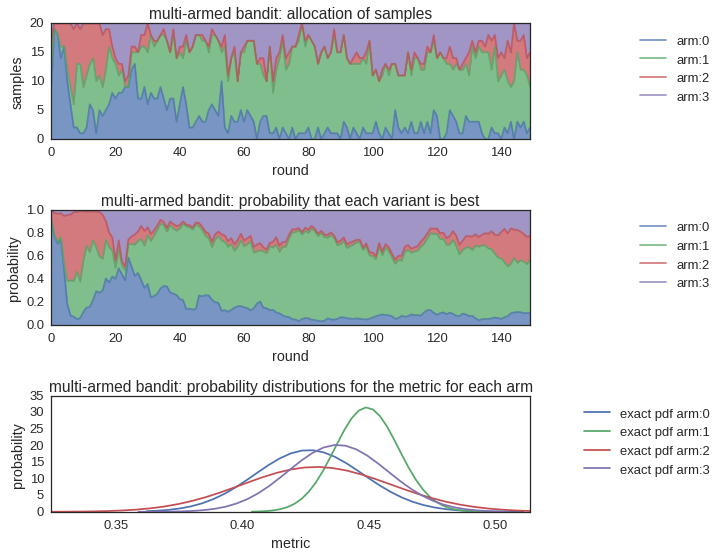

In [3]:
plt.figure(figsize=(8, 8))
ex.plot(legend_loc=(1.4, 1))

### One Variant is Best

In this second example, there is indeed an optimum variant, and the experiment identifies this optimum within about 80 experiment steps and then allocates almost all of its resources with that variant going forward. Of course, it does have to occasionally allocate resources to the other variants occasionally to reassure itself that we do indeed have the best variant.

In [4]:
arms = [ab.BinomBetaTestVariant(.45, 
                                prior=beta(1, 1),
                                name="suboptimum:{i}".format(i=i)) 
        for i in range(4)] + [
        ab.BinomBetaTestVariant(.55, 
                                prior=beta(1, 1),
                                name="optimum") 
        ]

ex = ab.MultiArmedBandit(arms=arms)

steps, samples_per_step = 150, 20

animation = ex.run_with_animation(steps, samples_per_step,
                                  ylim=[0, 25])

display_animation(animation)

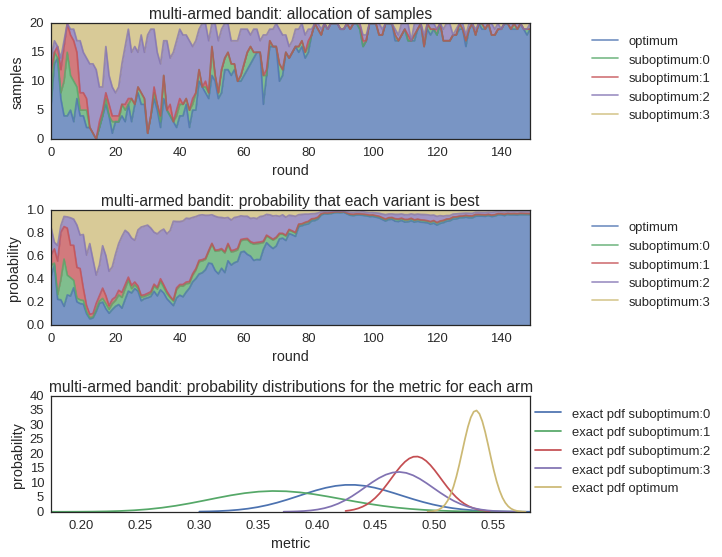

In [5]:
plt.figure(figsize=(8, 8))
ex.plot(legend_loc=(1.4, 1))